## Dual Governance Agent-based modelling



In [1]:
%pip show radcad

Name: radcad
Version: 0.13.0
Summary: A Python package for dynamical systems modelling & simulation, inspired by and compatible with cadCAD
Home-page: 
Author: CADLabs
Author-email: benschza@users.noreply.github.com
License: 
Location: /opt/anaconda3/envs/my-conda-env/lib/python3.12/site-packages
Requires: fn-py, numpy, pandas, pathos, py
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Dependences
import pandas as pd
import numpy as np

# radCAD
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

# Experiments
from model import run
from model.parts.utils import *

pd.options.display.float_format = "{:.2f}".format

%matplotlib inline

In [3]:
from model.state_variables import initial_state
from model.state_update_blocks import state_update_blocks
from model.sys_params import sys_params

MONTE_CARLO_RUNS = 1
TIMESTEPS = 100

model = Model(
    initial_state=initial_state,
    params=sys_params,
    state_update_blocks=state_update_blocks,
)
simulation = Simulation(model=model, timesteps=TIMESTEPS, runs=MONTE_CARLO_RUNS)

result = simulation.run()
df = pd.DataFrame(result)
rdf = run.postprocessing(df)

In [4]:
df.head()

,agents,actors,dg,proposals,proposals_new,time_manager,simulation,subset,run,substep,timestep
0,{861b56dc-f81d-45e1-89b4-cd3f6b6c3f46: {'st_am...,[StHolderActor(address='0x2fB385110957782d8eB3...,DualGovernance(state=DualGovernanceState(confi...,{},Proposals(state=ProposalState(last_canceled_pr...,TimeManager(current_time=datetime.datetime(202...,0,0,1,0,0
1,{861b56dc-f81d-45e1-89b4-cd3f6b6c3f46: {'st_am...,[StHolderActor(address='0x2fB385110957782d8eB3...,DualGovernance(state=DualGovernanceState(confi...,{},Proposals(state=ProposalState(last_canceled_pr...,TimeManager(current_time=datetime.datetime(202...,0,0,1,1,1
2,{861b56dc-f81d-45e1-89b4-cd3f6b6c3f46: {'st_am...,[StHolderActor(address='0x2fB385110957782d8eB3...,DualGovernance(state=DualGovernanceState(confi...,{},Proposals(state=ProposalState(last_canceled_pr...,TimeManager(current_time=datetime.datetime(202...,0,0,1,2,1
3,{861b56dc-f81d-45e1-89b4-cd3f6b6c3f46: {'st_am...,[StHolderActor(address='0x2fB385110957782d8eB3...,DualGovernance(state=DualGovernanceState(confi...,{},Proposals(state=ProposalState(last_canceled_pr...,TimeManager(current_time=datetime.datetime(202...,0,0,1,3,1
4,{861b56dc-f81d-45e1-89b4-cd3f6b6c3f46: {'st_am...,[StHolderActor(address='0x2fB385110957782d8eB3...,DualGovernance(state=DualGovernanceState(confi...,{},Proposals(state=ProposalState(last_canceled_pr...,TimeManager(current_time=datetime.datetime(202...,0,0,1,4,1


In [5]:
rdf.head()

,timestep,run,proposals_count,proposals_new_count,st_at_agents,dg_state,current_time,rqs
4,1,1,0,0,701194035640732800253952.00,1,2024-08-06 20:47:37.895996,0
8,2,1,0,0,701194035640732800253952.00,1,2024-08-06 21:47:37.895996,0
12,3,1,0,0,701194035640732800253952.00,1,2024-08-06 22:47:37.895996,0
16,4,1,0,0,701194035640732800253952.00,1,2024-08-06 23:47:37.895996,0
20,5,1,0,0,701194035640732800253952.00,1,2024-08-07 00:47:37.895996,0


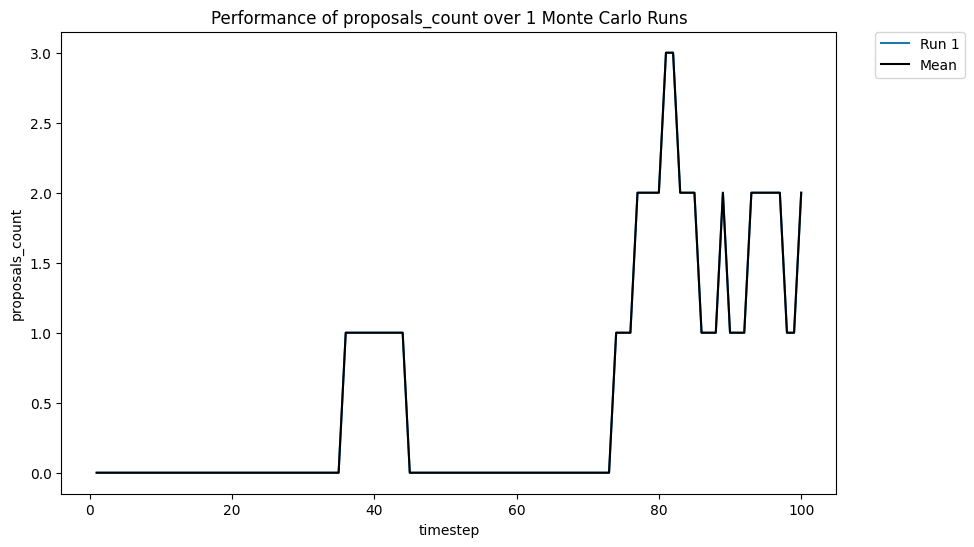

In [6]:
monte_carlo_plot(rdf, "timestep", "timestep", "proposals_count", 1)

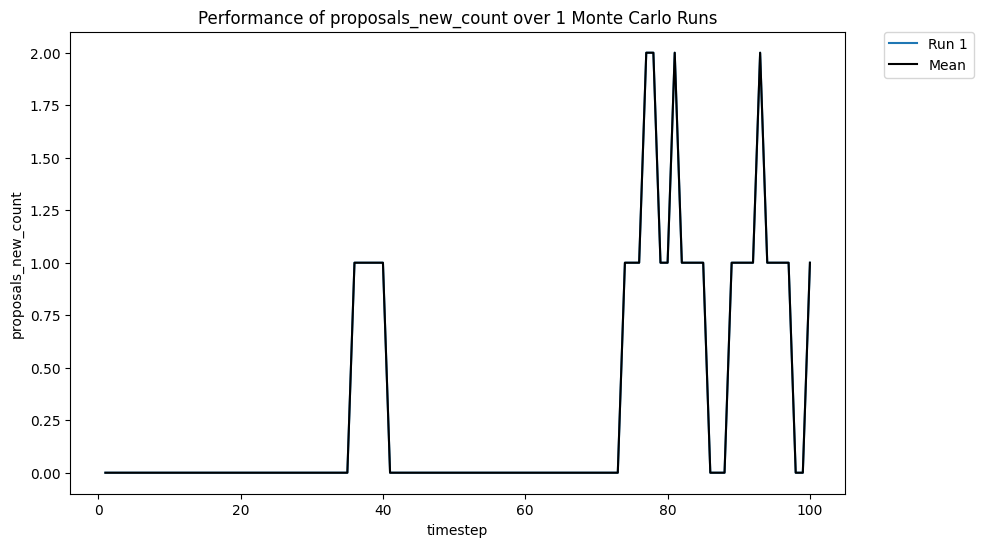

In [7]:
monte_carlo_plot(rdf, "timestep", "timestep", "proposals_new_count", 1)

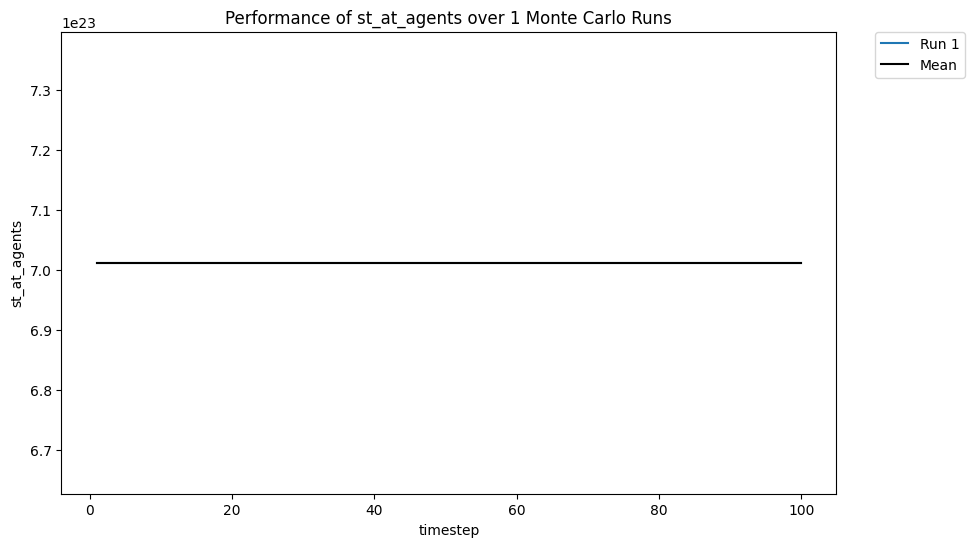

In [8]:
monte_carlo_plot(rdf, "timestep", "timestep", "st_at_agents", 1)

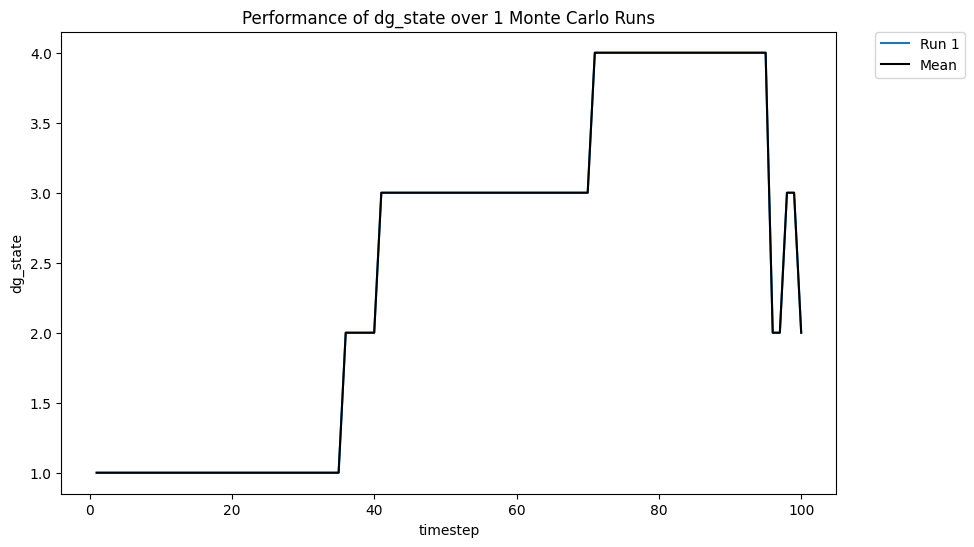

In [9]:
monte_carlo_plot(rdf, "timestep", "timestep", "dg_state", 1)

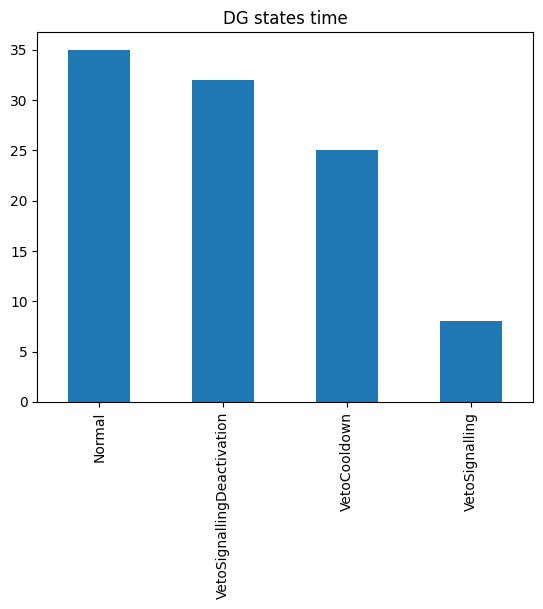

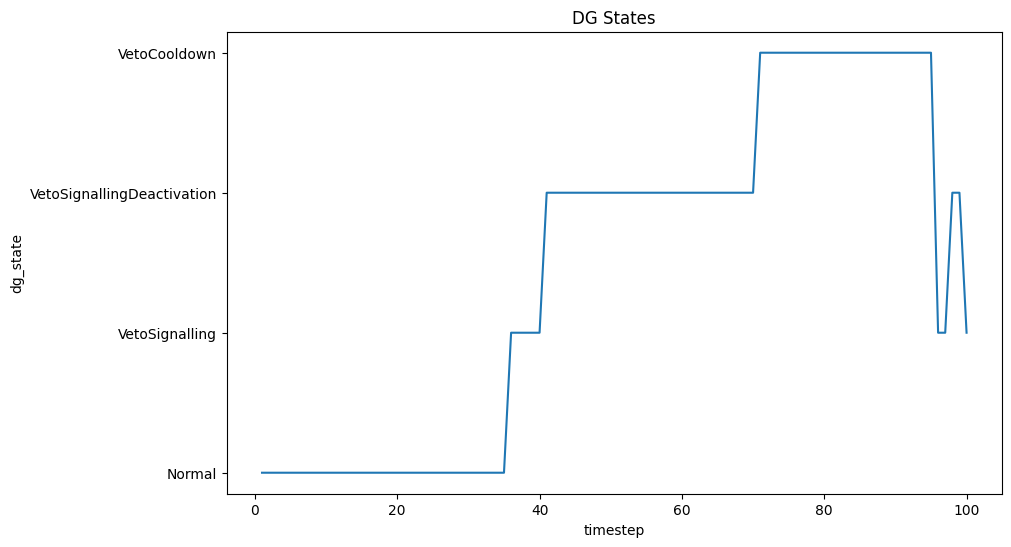

In [10]:
state_plot(rdf, "timestep", "dg_state", 1)

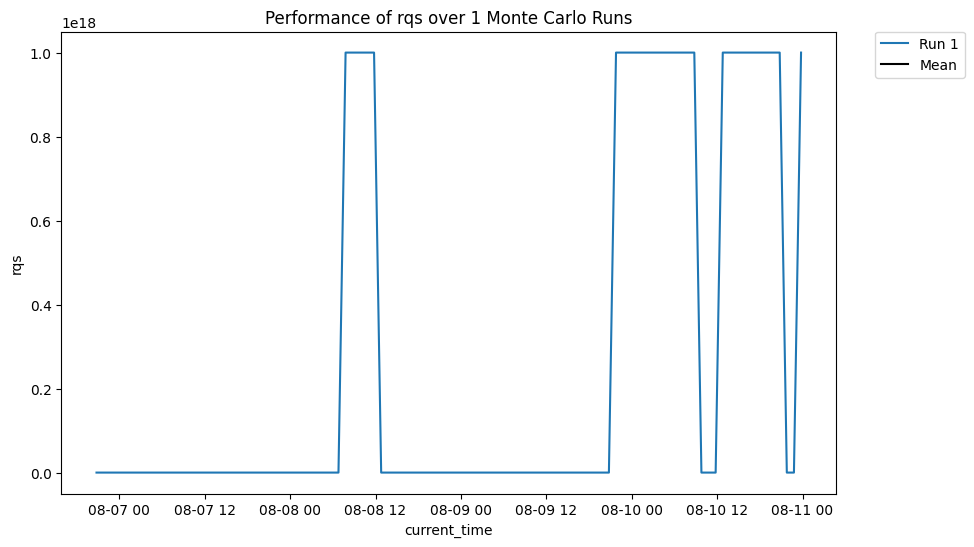

In [11]:
monte_carlo_plot(rdf, "timestep", "current_time", "rqs", 1)